In [6]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('words')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /home/aamir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/aamir/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
# read csv

df = pd.read_csv('/home/aamir/datasets/brexit.csv', header=0, names=['tweet'], encoding='utf-8')

In [8]:
# size of dataframe prior to dropping duplicates

df.shape

(364862, 1)

In [9]:
# drop duplicate tweets

df.drop_duplicates(inplace=True)

In [10]:
df.shape

(24820, 1)

In [11]:
# URLs, some other user_ids, numbers cleaning

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")

    return lst

In [12]:
df['tweet'] =  clean_tweets(df['tweet'])

In [13]:
# Convert to list
data = df.tweet.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove newline character \n or \\n
data = [re.sub(r"(?<!\\)\\n|\n", ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Removing string of length 1
data = [re.sub(r'(?:\b\w{,1}\s|\s\w{,1}\b|\b\w{,1}\b)', ' ', sent) for sent in data]

# Remove white spaces characters
data = [re.sub('\s+', ' ', sent) for sent in data]

pprint(data[:3])

[' just published "# TheStorm : How to prepare for global corruption purge ?" '
 '# FutureOfComms # MAGA …',
 ' If you want to repost this elsewhere , feel free . Hopefully it annoys the '
 'right people . ',
 ' So , is the # Johnson bluster about # NoDealBrexit simply to get MPs to '
 'accept instead bad - deal # Brexit ? He wants to bo …']


In [14]:
# tokenization

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['just', 'published', 'thestorm', 'how', 'to', 'prepare', 'for', 'global', 'corruption', 'purge', 'futureofcomms', 'maga'], ['if', 'you', 'want', 'to', 'repost', 'this', 'elsewhere', 'feel', 'free', 'hopefully', 'it', 'annoys', 'the', 'right', 'people']]


In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['just', 'published', 'thestorm', 'how', 'to', 'prepare', 'for', 'global', 'corruption', 'purge', 'futureofcomms', 'maga']


In [16]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'nan', '&amp', 'amp', 'xaa', 'xac', 'xa', 'xb', 'xc', 'xf', 'xe', 'co'])

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['publish', 'thestorm', 'prepare', 'global', 'corruption', 'purge', 'futureofcomms', 'maga']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('corruption', 1),
  ('futureofcomms', 1),
  ('global', 1),
  ('maga', 1),
  ('prepare', 1),
  ('publish', 1),
  ('purge', 1),
  ('thestorm', 1)]]

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.047*"britain" + 0.027*"new" + 0.018*"future" + 0.018*"economy" + '
  '0.017*"pound" + 0.016*"cameron" + 0.014*"may" + 0.014*"big" + 0.014*"live" '
  '+ 0.014*"european"'),
 (1,
  '0.051*"would" + 0.038*"take" + 0.034*"thing" + 0.030*"year" + 0.028*"die" + '
  '0.018*"tory" + 0.017*"der" + 0.015*"decision" + 0.014*"support" + '
  '0.014*"wake"'),
 (2,
  '0.044*"day" + 0.037*"london" + 0.034*"first" + 0.020*"ireland" + '
  '0.019*"already" + 0.016*"effect" + 0.014*"hit" + 0.013*"move" + '
  '0.012*"agree" + 0.010*"problem"'),
 (3,
  '0.068*"happen" + 0.032*"euro" + 0.026*"start" + 0.020*"believe" + '
  '0.017*"wonder" + 0.016*"real" + 0.016*"politic" + 0.015*"bring" + '
  '0.013*"feel" + 0.012*"free"'),
 (4,
  '0.032*"make" + 0.029*"s" + 0.026*"el" + 0.024*"come" + 0.021*"today" + '
  '0.018*"minute" + 0.018*"have" + 0.016*"call" + 0.015*"fuck" + 0.013*"lead"'),
 (5,
  '0.240*"brexit" + 0.025*"uk" + 0.020*"vote" + 0.015*"not" + 0.014*"leave" + '
  '0.011*"deal" + 0.010*"say" + 

In [23]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.44837127857184306


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/aamir/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.458371 -0.019681  1       1        55.347164
4     -0.020546  0.345186  2       1        8.132936 
0     -0.037681 -0.071979  3       1        7.124620 
1     -0.039161 -0.086172  4       1        5.686382 
8     -0.046689 -0.028678  5       1        5.376055 
7     -0.059927 -0.029120  6       1        4.194208 
6     -0.060765 -0.029455  7       1        4.162668 
9     -0.060818 -0.029672  8       1        3.838896 
2     -0.066159 -0.025256  9       1        3.407409 
3     -0.066625 -0.025175  10      1        2.729653 , topic_info=     Category          Freq       Term         Total  loglift  logprob
20    Default  29216.000000  brexit     29216.000000  30.0000  30.0000
110   Default  732.000000    britain    732.000000    29.0000  29.0000
116   Default  638.000000    would      638.000000    28.0000  28.0000
197   Default  533.000000    mean       533.000000    27.0000  27.0000
46    Default  3039.000000   uk         3039.000000   26.0000  26.0000
...       ...          ...   ..                 ...       ...      ...
2183  Topic10  37.874767     regard     38.845528     3.5757  -5.0661 
605   Topic10  35.611607     outcome    36.581711     3.5741  -5.1278 
2099  Topic10  34.952915     truth      35.923172     3.5736  -5.1464 
1390  Topic10  34.933247     continent  35.903790     3.5736  -5.1470 
619   Topic10  34.757133     cut        35.727303     3.5735  -5.1520 

[331 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
147    10     0.984247  act     
899    5      0.995023  actually
1817   7      0.972357  advisor 
770    5      0.989920  affect  
483    9      0.984422  agree   
...   ..           ...     ...  
690    4      0.982652  wrong   
247    4      0.996435  year    
1389   10     0.974063  yo      
816    3      0.994060  young   
10849  1      0.997602  και     

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 2, 9, 8, 7, 10, 3, 4])

In [25]:
# mallet implementation of LDA

import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = '/home/aamir/mallet-2.0.8'
mallet_path = '/home/aamir/mallet-2.0.8/bin/mallet' # update this path

In [26]:
# build mallet lda
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('brexit', 0.21330921857545615),
   ('europe', 0.0206393957125379),
   ('pour', 0.013245385392840045),
   ('https', 0.011064418320123412),
   ('france', 0.010213309218575457),
   ('une', 0.008670673972019788),
   ('point', 0.008191925102399064),
   ('tweet', 0.007979147827012076),
   ('du', 0.0076599819139315925),
   ('qui', 0.007021650087770626)]),
 (1,
  [('vote', 0.0868180209334075),
   ('brexit', 0.07346918137230116),
   ('leave', 0.06229458461849623),
   ('eu', 0.033068716185467965),
   ('britain', 0.03225969560600698),
   ('referendum', 0.02856853921221621),
   ('british', 0.026242605046265865),
   ('call', 0.01612984780300349),
   ('result', 0.013601658492187895),
   ('scotland', 0.012691510340294282)]),
 (2,
  [('uk', 0.09519166623903115),
   ('trump', 0.023451531790424387),
   ('trade', 0.016575152665879816),
   ('world', 0.015446194899163546),
   ('economy', 0.011956689074767794),
   ('london', 0.01134089392928619),
   ('market', 0.010417201211063785),
   ('lead', 0.0

In [27]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3498386557576979


In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

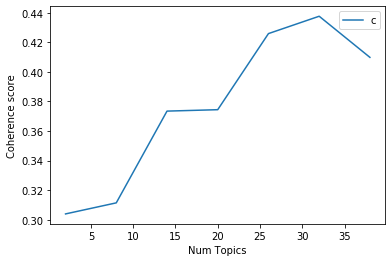

In [30]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3039
Num Topics = 8  has Coherence Value of 0.3114
Num Topics = 14  has Coherence Value of 0.3735
Num Topics = 20  has Coherence Value of 0.3744
Num Topics = 26  has Coherence Value of 0.4259
Num Topics = 32  has Coherence Value of 0.4377
Num Topics = 38  has Coherence Value of 0.4098


In [32]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(10,
  '0.200*"brexit" + 0.077*"europe" + 0.037*"result" + 0.034*"find" + '
  '0.025*"https" + 0.023*"national" + 0.021*"farage" + 0.020*"promise" + '
  '0.020*"bank" + 0.019*"wake" + 0.014*"send" + 0.014*"final" + '
  '0.012*"brussel" + 0.010*"panic" + 0.009*"warning"'),
 (9,
  '0.070*"brexit" + 0.063*"tory" + 0.048*"change" + 0.045*"remainer" + '
  '0.036*"democracy" + 0.022*"wrong" + 0.019*"poll" + 0.016*"brexitparty" + '
  '0.015*"ignore" + 0.014*"suggest" + 0.014*"accept" + 0.013*"daily" + '
  '0.013*"mind" + 0.011*"remoaner" + 0.010*"close"'),
 (16,
  '0.158*"uk" + 0.119*"brexit" + 0.047*"economy" + 0.042*"plan" + '
  '0.028*"affect" + 0.016*"pull" + 0.016*"meeting" + 0.014*"expert" + '
  '0.012*"oct" + 0.012*"damage" + 0.011*"official" + 0.010*"city" + '
  '0.010*"march" + 0.010*"bring" + 0.008*"collapse"'),
 (22,
  '0.255*"brexit" + 0.034*"end" + 0.031*"fuck" + 0.025*"love" + 0.023*"move" + '
  '0.016*"push" + 0.016*"freedom" + 0.014*"idiot" + 0.014*"care" + '
  '0.013*"feed" 

In [33]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,33.0,0.0572,"brexit, britain, great, lead, happen, exit, border, service, discuss, chance","just published ""# TheStorm : How to prepare for global corruption purge ?"" # FutureOfComms # MAGA …"
1,1,0.0,0.0421,"uk, trade, post, hard, deal, free, huge, uncertainty, agreement, line","If you want to repost this elsewhere , feel free . Hopefully it annoys the right people ."
2,2,26.0,0.0581,"deal, parliament, mps, mp, force, block, warn, boris_johnson, event, deliver","So , is the # Johnson bluster about # NoDealBrexit simply to get MPs to accept instead bad - deal # Brexit ? He wants to bo …"
3,3,26.0,0.0581,"deal, parliament, mps, mp, force, block, warn, boris_johnson, event, deliver",WATCH : coward Johnson refuses to allow our democratically elected Parliament to hold him to account over his undemocratic …
4,4,13.0,0.0572,"vote, leave, eu, remain, euref, britain, october, european_union, quit, voted","Why are Remainers so disgusted by this flag ? If you dont like it , please leave the UK . fucking love this flag and Im …"
5,5,27.0,0.1223,"call, idea, support, hear, turn, political, back, agree, https, brexiteer","Not only is he reflecting the Trump road to nowhere , his hair is looking similar too . Is he combing forward , everyone ? Wo …"
6,6,31.0,0.0429,"day, johnson, boris, boris_johnson, hope, backstop, merkel, borisjohnson, euref, brexit","Maybe the could explain what their alternative to back stop is , if cant …"
7,7,29.0,0.0562,"brexit, bad, london, euro, pound, fall, job, crash, stock, german",The combined UKIP and NUKIP vote has collapsed . The 52 % for # Brexit in 2016 has crashed to % in 2019 . Good job …
8,8,6.0,0.0414,"brexit, work, man, start, woman, continue, week, nhs, citizen, long","Do you know what ? fear he is right . Every time , he has been spot on . Are we about to get shafted again ? Is Boris THAT fuck …"
9,9,27.0,0.0523,"call, idea, support, hear, turn, political, back, agree, https, brexiteer",.... Any connection with string of flop political masters # Brexit ?😊 Also reflects …


In [34]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2153,"uk, trade, post, hard, deal, free, huge, uncertainty, agreement, line",: chilling out ask me anything talk comedy music news youtube twitch teamgodvek brexit nowplaying u20wc attackontitan breaking mondaymotivation memorialday teamemmmmsie supportsmallstreamers teamb42 co / iwvdjukutp nan nan nan
1,1.0,0.1893,"brexit, trump, win, stay, nodealbrexit, friend, president, stupid, american, police",interview with an ex muslim : islam is cult not religion co / bz5k7cywb5 maga brexit brexitparty america islam terrorism violence walkaway treason religionofpeace cult religion nan nan nan
2,2.0,0.1973,"brexit, late, big, market, global, open, risk, reaction, check, manage",: detailed work went into these documents at the core of workable plan to deliver proper brexit its managed and mutually beneficial transition to strong independent future for the uk allowing us freedom on the global stage whilst co / yat0uubypo nan nan nan
3,3.0,0.1831,"government, business, nodeal, issue, prepare, fact, thread, ready, interest, worry",: THREAD \ xf0 \ x9f \ x91 \ x8713 automotive # Brexit myths \ xe2 \ x80 \ x93 busted MYTH : The automotive industry shouldn \ xe2 \ x80 \ x99t worry about leaving the EU with # nodeal \ xe2 \ x80 \ xa6 his No Deal plans . Alastair Campbell has no interest in Labour bc he can \ xe2 \ x80 \ x99 \ xe2 \ x80 \ xa6 nan nan nan
4,4.0,0.3998,"che, si, su, ora, solo, con, corbyn, piu, della, una",: 15 vedremo ma credo che il labour si sia infilato in un vicolo cieco vagamente simile alla brexit uscirne adesso essendo allo stesso tempo credibili sar difficile perch ripeto leuropa una cosa seria ogni posizione legittima ma lambiguita la scelta peggiore co / ha0vh0njca nan nan nan


In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,33.0,"brexit, britain, great, lead, happen, exit, border, service, discuss, chance",848.0,0.0342
1.0,0.0,"uk, trade, post, hard, deal, free, huge, uncertainty, agreement, line",657.0,0.0265
2.0,26.0,"deal, parliament, mps, mp, force, block, warn, boris_johnson, event, deliver",698.0,0.0281
3.0,26.0,"deal, parliament, mps, mp, force, block, warn, boris_johnson, event, deliver",773.0,0.0311
4.0,13.0,"vote, leave, eu, remain, euref, britain, october, european_union, quit, voted",758.0,0.0305
5.0,27.0,"call, idea, support, hear, turn, political, back, agree, https, brexiteer",545.0,0.0220
6.0,31.0,"day, johnson, boris, boris_johnson, hope, backstop, merkel, borisjohnson, euref, brexit",640.0,0.0258
7.0,29.0,"brexit, bad, london, euro, pound, fall, job, crash, stock, german",708.0,0.0285
8.0,6.0,"brexit, work, man, start, woman, continue, week, nhs, citizen, long",591.0,0.0238
9.0,27.0,"call, idea, support, hear, turn, political, back, agree, https, brexiteer",757.0,0.0305


In [36]:
df_dominant_topics = df_dominant_topics.drop_duplicates()

In [37]:
df_dominant_topics.sort_values(['Dominant_Topic'], ascending=False)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
50.0,37.0,"brexit, voter, show, feel, understand, nation, war, true, majority, view",NaN,NaN
55.0,36.0,"par, ireland, give, prove_proroguing, question, stop, problem, peers_trye, irish, number",NaN,NaN
21.0,36.0,"par, ireland, give, prove_proroguing, question, stop, problem, peers_trye, irish, number",383.0,0.0154
496.0,35.0,"pour, une, du, qui, ca, pas, les, ce, dan, est",NaN,NaN
54.0,34.0,"brexit, scotland, england, eurefresult, side, independence, result, indyref, decide, chaos",NaN,NaN
0.0,33.0,"brexit, britain, great, lead, happen, exit, border, service, discuss, chance",848.0,0.0342
163.0,33.0,"brexit, britain, great, lead, happen, exit, border, service, discuss, chance",NaN,NaN
36.0,33.0,"brexit, britain, great, lead, happen, exit, border, service, discuss, chance",609.0,0.0245
12.0,33.0,"brexit, britain, great, lead, happen, exit, border, service, discuss, chance",429.0,0.0173
118.0,32.0,"brexit, thing, part, en, reason, policy, democratic, http, give, donald_trump",NaN,NaN


In [38]:
exportdf_dominant_topics = df_dominant_topics.to_csv('/home/aamir/datasets/df_dominant_topics.csv', index = None)

In [39]:
exportdf_sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.to_csv('/home/aamir/datasets/sent_topics_sorteddf_mallet.csv', index = None)

In [40]:
exportdf_dominant_topic = df_dominant_topic.to_csv('/home/aamir/datasets/df_dominant_topic.csv', index = None)